In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np

print("Tensorflow version " + tf.__version__)

2022-12-14 04:57:09.505830: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-14 04:57:09.505945: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  grpc://10.0.0.2:8470


2022-12-14 04:57:18.233099: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-14 04:57:18.236184: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-14 04:57:18.236223: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 04:57:18.236253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (95ec1f2b8485): /proc/driver/nvidia/version does not exist
2022-12-14 04:57:18.239682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [5]:
IMAGE_SIZE = [512, 512] # at this size, a GPU will run out of memory. Use the TPU
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    print(label)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    
    return image, idnum # returns a dataset of image(s)
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + 
                                            '/tfrecords-jpeg-192x192/train/*.tfrec'), labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + 
                                            '/tfrecords-jpeg-192x192/val/*.tfrec'), labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset
def get_test_dataset(ordered=False):
    dataset = load_dataset(tf.io.gfile.glob(GCS_DS_PATH + 
                                            '/tfrecords-jpeg-192x192/test/*.tfrec'), labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

2022-12-14 04:59:46.931111: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Tensor("Cast:0", shape=(), dtype=int32)
Tensor("Cast:0", shape=(), dtype=int32)


2022-12-14 04:59:47.198331: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Input, Flatten, BatchNormalization

# with strategy.scope():    
#     pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,
# input_shape=[*IMAGE_SIZE, 3])
#     pretrained_model.trainable = True # transfer learning
    
#     model = tf.keras.Sequential([
#         pretrained_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(256, activation='relu'),
#         tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Dense(104, activation='softmax')
#     ])

with strategy.scope(): 
    pretrained_model = tf.keras.applications.ResNet152V2(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False
    
    model = tf.keras.Sequential([
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(104, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

model.summary()


def get_model(IMAGE_SIZE):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3), data_format = 'channels_last'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(Conv2D(256, (5, 5), activation='relu'))
#     model.add(Conv2D(256, (5, 5), activation='relu'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(104, activation='softmax'))

    model.summary()
    return model

234553344/234545216 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 16, 16, 2048)      58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 104)               26728     
Total params: 59,538,792
Trainable params: 1,207,144
No

In [9]:
historical = model.fit(training_dataset, 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=15, 
          validation_data=validation_dataset)

Epoch 1/15
99/99 [==============================] - 137s 1s/step - loss: 3.4766 - sparse_categorical_accuracy: 0.2542 - val_loss: 1.6354 - val_sparse_categorical_accuracy: 0.6239


2022-12-14 05:04:27.991000: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 50483, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670994267.987633173","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 50483, Output num: 1","grpc_status":3}


Epoch 2/15
99/99 [==============================] - 60s 611ms/step - loss: 1.7018 - sparse_categorical_accuracy: 0.5776 - val_loss: 1.0954 - val_sparse_categorical_accuracy: 0.7220
Epoch 3/15
99/99 [==============================] - 59s 604ms/step - loss: 1.2162 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.8974 - val_sparse_categorical_accuracy: 0.7802
Epoch 4/15
99/99 [==============================] - 60s 608ms/step - loss: 0.9086 - sparse_categorical_accuracy: 0.7542 - val_loss: 0.7860 - val_sparse_categorical_accuracy: 0.8023
Epoch 5/15
99/99 [==============================] - 60s 609ms/step - loss: 0.7336 - sparse_categorical_accuracy: 0.7988 - val_loss: 0.7168 - val_sparse_categorical_accuracy: 0.8203
Epoch 6/15
99/99 [==============================] - 60s 605ms/step - loss: 0.6040 - sparse_categorical_accuracy: 0.8324 - val_loss: 0.6806 - val_sparse_categorical_accuracy: 0.8244
Epoch 7/15
99/99 [==============================] - 60s 607ms/step - loss: 0.4890 - sparse_cate

In [10]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

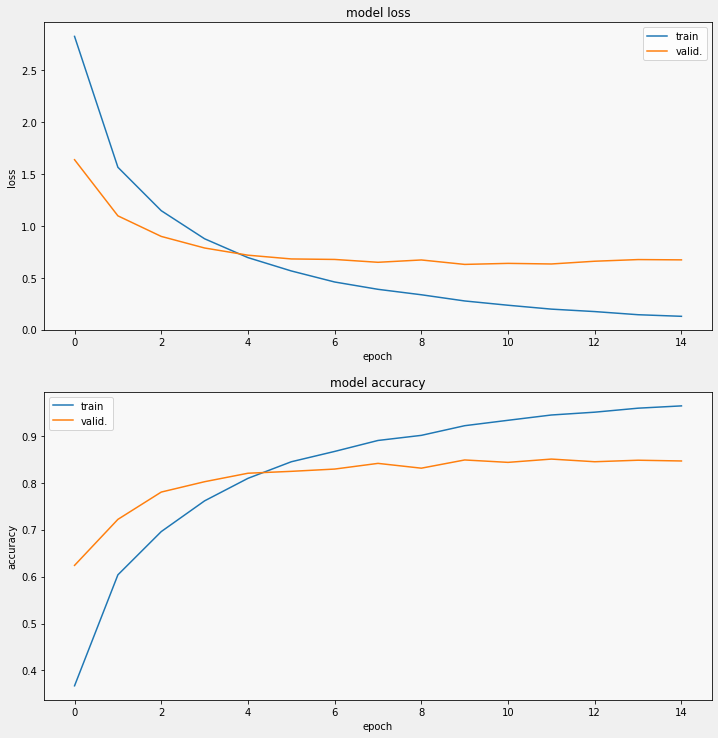

In [14]:
from matplotlib import pyplot as plt
display_training_curves(historical.history['loss'], historical.history['val_loss'], 'loss', 211)
display_training_curves(historical.history['sparse_categorical_accuracy'], historical.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

In [15]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

2022-12-14 05:20:42.008364: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Computing predictions...
[67 52 68 ... 14 40 79]


2022-12-14 05:21:38.003147: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 66427, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670995298.002529443","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 66427, Output num: 0","grpc_status":3}
